In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR
using Nevanlinna

In [2]:
T = BigFloat

BigFloat

In [3]:
beta::Float64 = 100
wmax::Float64 = 10
basis = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 

FiniteTempBasisSet with β = 100.0, ωmax = 10.0

In [4]:
include("../flex_src/IRFLEX.jl")

Main.IRFLEX

In [46]:
nsize::Int64 = 4096
t_pra::Float64 = 0.0
filling::Float64 = 1.0
U::Float64 = 0.4 ##w=4
#U::Float64 = 0.2 ##w=2
function single_Hami(x::Float64, y::Float64, t::Float64, t_pra::Float64)::Float64
    e::Float64 = -2.0*t*(cos(x)+cos(y)) + 4.0*t_pra*cos(x)*cos(y)                   
end
hami::Function = (x,y) -> single_Hami(x,y,0.5,t_pra)
#U::Float64 = 0.5
#hami::Function = (x,y) -> IRFLEX.single_Hami(x,y,t_pra)
lat = IRFLEX.SingleLatticeModel(nsize, filling, U, SparseIR.β(basis), hami)
;

In [6]:
ratio_U = 0.0
precision = 1e-4
loose_precision = 1e+3*precision
gkf0 = IRFLEX.make_free_giw(lat, basis)
;

In [7]:
# Compute chi0
chi0kf = IRFLEX.calc_chi0(gkf0, lat, basis)
;

In [47]:
# Compute chi
chiskf = chi0kf ./ (1.0 .- lat.U*chi0kf)
;

In [8]:
hnw = (length(basis.smpl_wn_b.sampling_points)-1)÷2

36

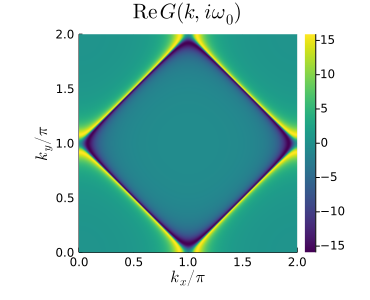

In [9]:
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(gkf0[hnw+1,:,:]), 
    title=latexstring("\\mathrm{Re}\\,G(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

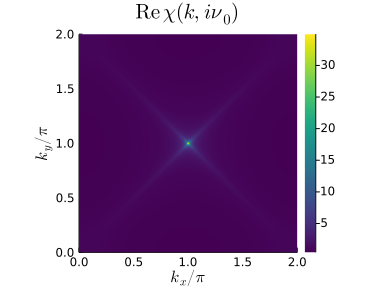

In [48]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(chiskf[hnw+1,:,:]),
    title=latexstring("\\mathrm{Re}\\,\\chi(k,i\\nu_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"),
    c=:viridis,
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

In [11]:
#smpl_wn_b = SparseIR.default_matsubara_sampling_points(basis.basis_b)
#smpl_wn_b = smpl_wn_b[smpl_wn_b .!= BosonicFreq(0)]
#smpl_wn_b_wo_zero = MatsubaraSampling(basis.basis_b, smpl_wn_b)
;

In [50]:
chisf = chiskf[:,nsize÷2+1, nsize÷2+1]
#deleteat!(chisf, hnw+1)
#chisl = fit(smpl_wn_b_wo_zero, chisf, dim=1)
#chisf[37] = 0
chisl = fit(basis.smpl_wn_b, chisf, dim=1)
;

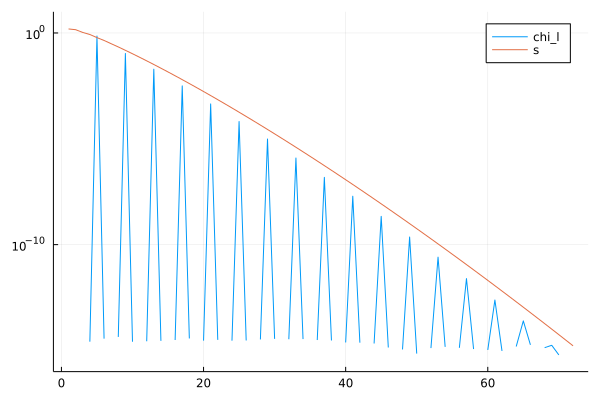

GKS: Number of points is invalid in routine POLYLINE


In [52]:
plot(yaxis=:log,ylims=(1e-16,10))
#plot()
plot!(real.(chisl),label="chi_l")
plot!(real.(basis.basis_b.s),label="s")

In [53]:
#smpl_wn_b_dense = MatsubaraSampling(basis.basis_b, SparseIR.BosonicFreq.(collect(-2332:2:2332)))
#chisl_d = fit(basis.smpl_wn_b, chisf)
#chisf_d = evaluate(smpl_wn_b_dense, chisl_d)
#deleteat!(chisf_d, 1167)
#chisf_d[1167]=0.0
#chisl_d = fit(smpl_wn_b_dense, chisf_d)
;

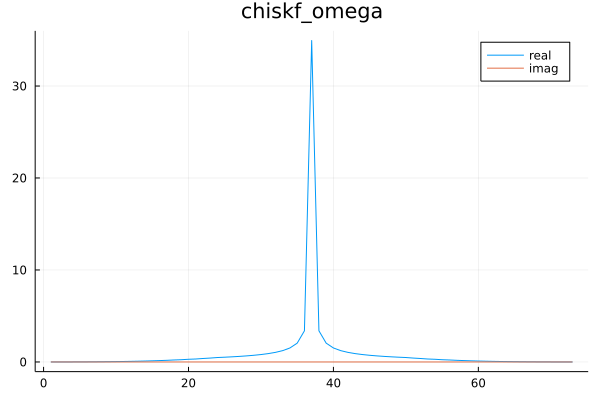

In [54]:
plot(title="chiskf_omega")
plot!(real.(chisf), label="real")
plot!(imag.(chisf), label="imag")

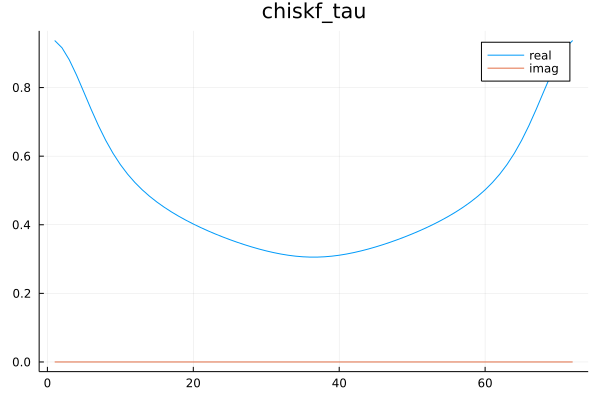

In [55]:
chist = evaluate(basis.smpl_tau_b, chisl)
plot(title="chiskf_tau")
plot!(real.(chist[:]), label="real")
plot!(imag.(chist[:]), label="imag")

In [56]:
chisw = evaluate(basis.smpl_wn_f, chisl)
;

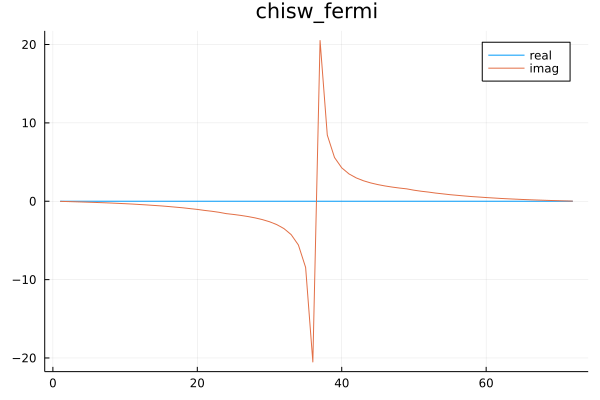

In [57]:
plot(title="chisw_fermi")
plot!(real.(chisw[:]), label="real")
plot!(imag.(chisw[:]), label="imag")

In [58]:
sum_rule = real(dot(basis.basis_f.u(SparseIR.β(basis)), chisl) + dot(basis.basis_f.u(0), chisl))

1.8846060006954934

In [59]:
setprecision(512)

512

In [60]:
input_chi  = Array{Complex{T}}(undef, hnw) 
input_smpl = Array{Complex{T}}(undef, hnw) 
;

In [61]:
for i in 1:hnw
    input_smpl[i] = SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(basis))
    input_chi[i]  = -chisw[hnw+i]
end

In [62]:
N_real    =  10000
omega_max =  10.0
eta       =  0.01
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
#1000 → 2000
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, input_smpl, input_chi)
#N_imag = hnw 
println("N_imag $(N_imag)")

N_imag is setted as 29
N_imag 29


In [63]:
imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum_rule, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


true

In [25]:
function exact_suscep(qx, qy, omega, nsize, beta, hami)
    chi = zeros(ComplexF64, length(omega))
    for iomega in 1:length(omega)
        for ix in 1:nsize, iy in 1:nsize
            kx::Float64 = 2*π*(ix-1)/nsize
            ky::Float64 = 2*π*(iy-1)/nsize
            ek  = hami(kx,ky)
            ekq = hami(kx-qx,ky-qy)
            chi[iomega] += -(IRFLEX.fermi_dirac(ekq,beta)-IRFLEX.fermi_dirac(ek,beta))/(omega[iomega]+ekq-ek)
        end
        chi[iomega] = chi[iomega]/(nsize*nsize)
    end
    return chi
end

exact_suscep (generic function with 1 method)

In [26]:
exa_freq = Array{Complex{T}}(collect(LinRange(-omega_max, omega_max, 1000))) .+ eta * im
exa_chi = exact_suscep(π,π,ComplexF64.(exa_freq),nsize,SparseIR.β(basis),hami)
;

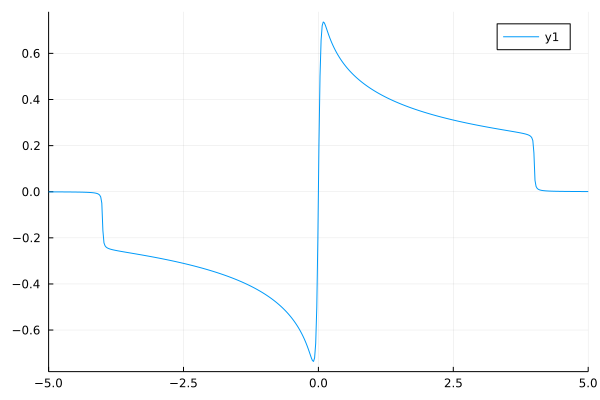

In [27]:
plot(xlim = [-5,5])
plot!(real.(exa_freq), imag.(exa_chi))

In [65]:
exa_chis = exa_chi ./ (1.0 .- lat.U*exa_chi)
;

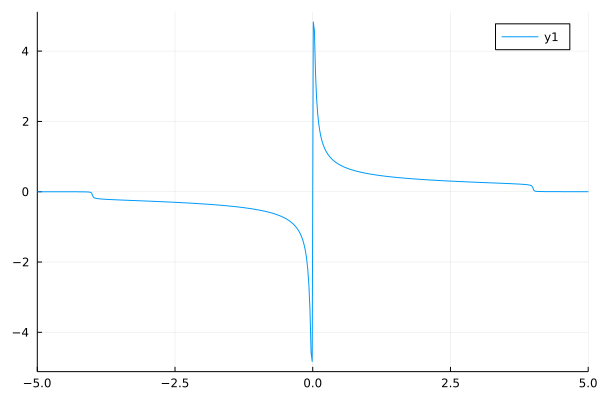

In [66]:
plot(xlim = [-5,5])
plot!(real.(exa_freq), imag.(exa_chis))

In [67]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, input_smpl, input_chi, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     1.541777e+03     1.762402e+03
 * time: 0.00021600723266601562
     1     9.993753e+02     9.810959e+02
 * time: 10.242162942886353
     2     9.623415e+02     8.838658e+02
 * time: 17.66453194618225
     3     9.452701e+02     7.934130e+02
 * time: 28.875427961349487
     4     9.081164e+02     4.075424e+02
 * time: 31.3182430267334
     5     8.942583e+02     3.805308e+02
 * time: 32.79138207435608
     6     8.701259e+02     1.810976e+01
 * time: 35.00552201271057
     7     8.680148e+02     6.690125e+01
 * time: 37.233134031295776
     8     8.670528e+02     3.817948e+01
 * time: 39.43552899360657
     9     8.668096e+02     2.787672e+00
 * time: 40.91005206108093
    10     8.668054e+02     1.129176e-01
 * time: 42.39321708679199
    11     8.668054e+02     3.022686e-02
 * time: 44.66072106361389
    12     8.668054e+02     1.306935e-03
 * time: 46.200600147247314
    13     8.668054e+02 

In [68]:
@time Nevanlinna.solve!(sol)
;

H=1
Iter     Function value   Gradient norm 
     0     8.668054e+02     7.740478e-10
 * time: 0.00019097328186035156
max_theta=0.665057689015928598544798805531621526938250223977769142291079738807122276671343190623205230637410149527716458820551115577183117874240005220177686300400811382
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     8.668054e+02     4.054901e+01
 * time: 0.0001938343048095703
     1     8.665148e+02     4.688708e+01
 * time: 14.500723838806152
     2     8.587876e+02     4.964310e+01
 * time: 21.17572283744812
     3     8.483006e+02     3.180707e+01
 * time: 25.29150104522705
     4     8.459111e+02     2.737656e+01
 * time: 27.785202026367188
     5     8.440773e+02     3.413771e+01
 * time: 30.33234190940857
     6     8.424539e+02     2.107062e+01
 * time: 32.05833601951599
     7     8.369793e+02     2.032318e+01
 * time: 34.545799016952515
     8     8.360525e+02     7.138517e+00
 * time: 38.50030303001404
     9     8.3568

     1     8.178975e+02     4.380018e+01
 * time: 5.777949094772339
     2     8.168818e+02     3.456978e+01
 * time: 19.567660093307495
     3     8.105070e+02     4.973254e+01
 * time: 24.880872011184692
     4     8.060044e+02     4.601507e+01
 * time: 28.551671028137207
     5     8.049883e+02     4.398909e+01
 * time: 34.64133310317993
     6     8.019135e+02     4.594316e+01
 * time: 38.38133001327515
     7     7.979885e+02     5.375001e+01
 * time: 42.134143114089966
     8     7.953939e+02     2.906059e+01
 * time: 50.024803161621094
     9     7.947318e+02     2.469755e+01
 * time: 54.469184160232544
    10     7.936849e+02     1.563738e+01
 * time: 57.39480900764465
    11     7.931940e+02     1.287635e+01
 * time: 66.4353539943695
    12     7.922776e+02     1.048213e+01
 * time: 69.91961312294006
    13     7.916767e+02     8.914619e+00
 * time: 73.61957001686096
    14     7.906081e+02     5.179651e+00
 * time: 79.72573614120483
    15     7.897548e+02     1.130741e+01
 *

    41     7.688617e+02     5.288755e-02
 * time: 183.70588493347168
    42     7.688617e+02     2.946247e-02
 * time: 186.46409392356873
    43     7.688617e+02     3.054663e-02
 * time: 189.51015210151672
    44     7.688617e+02     1.329759e-02
 * time: 192.55582809448242
    45     7.688617e+02     2.168727e-02
 * time: 195.60205602645874
    46     7.688617e+02     1.288193e-02
 * time: 203.0083110332489
    47     7.688617e+02     1.327503e-02
 * time: 205.17522192001343
    48     7.688617e+02     5.660187e-03
 * time: 207.73549389839172
    49     7.688617e+02     5.426730e-03
 * time: 210.41724610328674
    50     7.688617e+02     2.804971e-03
 * time: 213.09234595298767
    51     7.688617e+02     3.566345e-03
 * time: 215.7746798992157
    52     7.688617e+02     2.207393e-03
 * time: 218.39827799797058
    53     7.688617e+02     1.917447e-03
 * time: 221.04726910591125
    54     7.688617e+02     9.705592e-04
 * time: 223.7337989807129
    55     7.688617e+02     7.421719e

    66     7.414293e+02     1.283725e-04
 * time: 322.6560459136963
    67     7.414293e+02     1.306119e-04
 * time: 325.29272985458374
    68     7.414293e+02     1.003860e-04
 * time: 328.258437871933
    69     7.414293e+02     5.142042e-05
 * time: 331.10450983047485
    70     7.414293e+02     3.143808e-05
 * time: 333.9586617946625
    71     7.414293e+02     3.455764e-05
 * time: 337.2631938457489
    72     7.414293e+02     2.121066e-05
 * time: 340.562118768692
    73     7.414293e+02     1.877526e-05
 * time: 343.86262583732605
    74     7.414293e+02     1.256703e-05
 * time: 355.5317449569702
    75     7.414293e+02     1.533235e-05
 * time: 357.9023668766022
    76     7.414293e+02     1.004715e-05
 * time: 360.41621589660645
    77     7.414293e+02     7.531162e-06
 * time: 362.83380699157715
    78     7.414293e+02     5.266661e-06
 * time: 365.26167488098145
    79     7.414293e+02     4.629794e-06
 * time: 367.6692759990692
    80     7.414293e+02     3.160279e-06
 * 

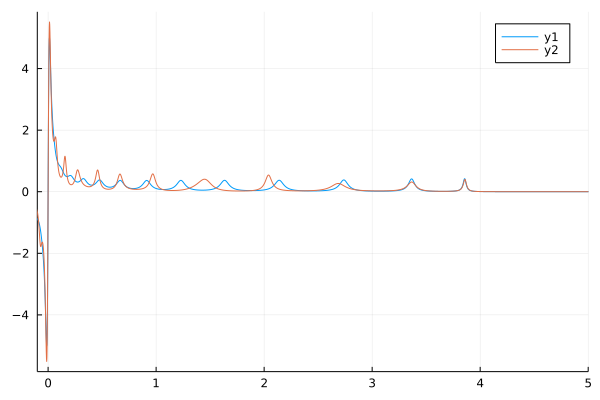

In [69]:
plot(xlim = [-0.1,5])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
plot!(real.(sol.reals.freq), imag.(sol.reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))

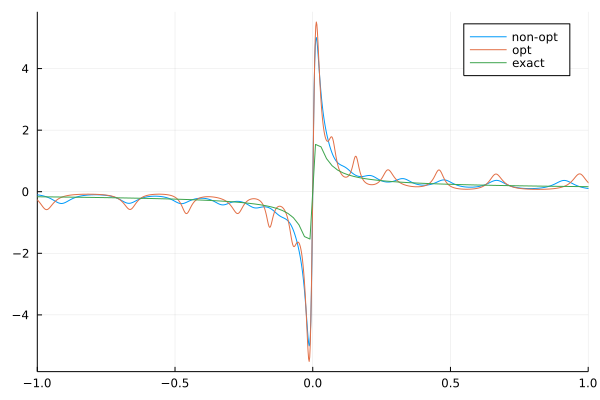

In [79]:
plot(xlim = [-1,1])
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)),label="non-opt", marker=:+)
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)),label="non-opt")
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)),label="opt")
plot!(real.(exa_freq), imag.(exa_chis)/pi,label="exact")

In [80]:
plot(xlim = [-2,8])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi),marker=:+)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)))

In [35]:
ComplexF64.(raw_reals.freq[1])

-10.0 + 0.01im